In [5]:
import sqlite3, io,tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from sknetwork.ranking import PageRank
import statsmodels.stats.proportion as smp
from scipy import spatial
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import HDBSCAN
from collections import Counter
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

In [6]:
import sys
print(sys.executable)

/opt/anaconda3/envs/tensorflow/bin/python


In [7]:
import contractions

# Extract Data

In [8]:
sql_db_path = 'SubredditData.db'

In [9]:
connection = sqlite3.connect('SubredditData.db')
cursor = connection.cursor()

In [10]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Number of tables: {len(tables)}")

Number of tables: 850


In [11]:
df = pd.read_sql_query("SELECT * FROM AmItheAsshole", connection)

In [12]:
df.describe

<bound method NDFrame.describe of         post_id                                                url  \
0    t3_1h2ck8c  https://www.reddit.com/r/AmItheAsshole/comment...   
1    t3_1h2ck07  https://www.reddit.com/r/AmItheAsshole/comment...   
2    t3_1h2cjzc  https://www.reddit.com/r/AmItheAsshole/comment...   
3    t3_1h2cd6o  https://www.reddit.com/r/AmItheAsshole/comment...   
4    t3_1h2c71b  https://www.reddit.com/r/AmItheAsshole/comment...   
..          ...                                                ...   
844  t3_1h3xp79  https://www.reddit.com/r/AmItheAsshole/comment...   
845  t3_1h3xjkp  https://www.reddit.com/r/AmItheAsshole/comment...   
846  t3_1h3xdsr  https://www.reddit.com/r/AmItheAsshole/comment...   
847  t3_1h3wnsj  https://www.reddit.com/r/AmItheAsshole/comment...   
848  t3_1h3weyp  https://www.reddit.com/r/AmItheAsshole/comment...   

     comment_count                created_timestamp title  ups  \
0                2  2024-11-29T03:22:11.159000+0000  None  

In [13]:
df.iloc[0]["url"]

'https://www.reddit.com/r/AmItheAsshole/comments/1h2ck8c/aita_for_offering_to_buy_my_aunt_a_birthday_gift/'

# Process Post Text Content

In [14]:
import re, string, random

In [15]:
posts_texts = df['text_content'].tolist()


In [16]:
def  all_sentences_one_list(posts_texts):
    all_texts = []
    for post_text in posts_texts:
        split_text = re.split('[!?.]', post_text.decode('utf-8'))
        for new_sentence in split_text:
            new_sentence = new_sentence.strip()
            new_sentence = contractions.fix(new_sentence)
            if new_sentence:
                all_texts.append(new_sentence)  
    return all_texts

In [17]:
all_texts = all_sentences_one_list(posts_texts)

In [45]:
def clean_1text_(sentences):
    all_word_tokens = []
    tokenized_sentences = []
    all_texts = []
    for s in sentences:
        s = s.strip()  
        s = contractions.fix(s)
        s = re.sub(r'\d+','',s).strip()        
        s = re.sub(r'[!?():;,\'".]', '', s)
        
        s = s.lower()       
        for w in s.split():
            if w:
                all_word_tokens.append(w)
        all_texts.append(s)
        s = [w for w in s.split()]
        
        tokenized_sentences.append(s)
    return tokenized_sentences, all_word_tokens, all_texts
tokenized_sentences, all_word_tokens, all_texts = clean_1text_(all_texts)

341835


In [ ]:
tokenized_sentences

In [ ]:
print(f"Tokens_vocab, unique words in a list #: {len(tokens_for_vocab)}")
print(f"Tokens, tokenized words inside list of list of sentences #: {len(tokenized_sentences)}")

In [19]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for token in all_word_tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1
vocab_size = len(vocab)
inverse_vocab = {index: token for token, index in vocab.items()}
print(f"Vocab size: {vocab_size}")

Vocab size: 12482


# Gender & Age

In [216]:
post_text_content_ =df["text_content"]
numbers =[]
j=0
for s in post_text_content_:
    
    s = s.decode('utf-8')
    n = re.findall(r'(\D{0,4})(\d+)(\D{0,3})', s)
 
    if n:
        instance = []
        cleaner_instance = []

        for n_i in n:
            
            before, number, after = n_i
            
            if 'f' in after.lower():
                after = 'F'
            elif 'm' in after.lower():
                after = 'M'     
            elif 'f' in before.lower():
                after = 'F'
            elif 'm' in before.lower():
                after = 'M'
            else:
                after = ''

            
            number = int(number)
            number = number if number < 90 and number > 13 else None
            if ('me' in before.lower() or 'i' in before.lower()) and not instance:
                instance = [number, after]
            else:
                cleaner_instance.append([number, after])
        if not instance:
       
            for c_i in cleaner_instance:
                
                if c_i[0] is not None:
                    instance = c_i

        
        if not instance:
            instance = cleaner_instance[0]
            
        if instance[0] is None:
            instance[1]=None  
                        
        numbers.append(instance) 
        
    else:
        numbers.append([None,None])
        
    j += 1
print(len(numbers))

849


In [217]:
gender_age = pd.DataFrame(numbers, columns=["Age","Gender"])
pd.set_option('display.max_colwidth', None)

gender_age['url'] = df['url']
# print(gender_age.head(20))
pd.reset_option('display.max_colwidth')

In [218]:
pd.set_option('display.max_colwidth', None)
print(gender_age[gender_age["Age"] < 15]["url"])
gender_age[gender_age["Age"] < 15]["Age"]

113        https://www.reddit.com/r/AmItheAsshole/comments/1h0l30n/aita_for_telling_my_friend_im_not_having_this/
159          https://www.reddit.com/r/AmItheAsshole/comments/1h04b36/aita_for_not_letting_my_brother_get_his_way/
162     https://www.reddit.com/r/AmItheAsshole/comments/1gzwdpg/aita_for_ruining_my_brothers_childhood_memory_by/
273                         https://www.reddit.com/r/AmItheAsshole/comments/1h3pkv4/aita_for_not_going_to_church/
279     https://www.reddit.com/r/AmItheAsshole/comments/1h3o3ol/aita_for_telling_my_mom_what_to_do_with_her_life/
475    https://www.reddit.com/r/AmItheAsshole/comments/1gsgz4y/aita_for_being_sarcastic_when_my_stepmother_asked/
493    https://www.reddit.com/r/AmItheAsshole/comments/1h1vp4r/aita_for_telling_my_parents_their_marriage_is_sad/
569          https://www.reddit.com/r/AmItheAsshole/comments/1h6t6m7/aitah_for_telling_my_stepmother_to_fuck_off/
659                       https://www.reddit.com/r/AmItheAsshole/comments/1h5us15/aita_f

113    14.0
159    14.0
162    14.0
273    14.0
279    14.0
475    14.0
493    14.0
569    14.0
659    14.0
699    14.0
740    14.0
773    14.0
Name: Age, dtype: float64

In [219]:
gender_age[(gender_age["Age"].notnull()) & (gender_age["Gender"] == "F")]

,Age,Gender,url
2,34.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h2cjzc/aita_for_refusing_to_let_my_brothers_new/
3,17.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h2cd6o/aita_for_making_my_uncle_walk_away_from_dinner/
5,25.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h2bxzj/aita_for_having_boundaries_regarding_guests_with/
6,20.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h2bvul/wibta_for_telling_my_online_friend_20m_this_is/
13,15.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h2at9k/wibta_if_i_stopped_being_respectful_and_quiet_to/
...,...,...,...
831,27.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h41obf/aita_for_doubting_my_mentally_ill_boyfriend/
834,19.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h40elo/aita_for_trying_to_help_an_injured_friend/
841,25.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h3yhsi/aita_for_asking_my_parents_to_wait_till_they/
843,18.0,F,https://www.reddit.com/r/AmItheAsshole/comments/1h3xphh/aita_for_telling_my_friend_he_doesnt_have_adhd/


% of Users that declared Gender:  0.6478209658421673
% of Users that declared Gender:  0.6478209658421673


([<matplotlib.axis.XTick at 0x3a5f71fa0>,
 [Text(1, 0, 'F'), Text(2, 0, 'M')])

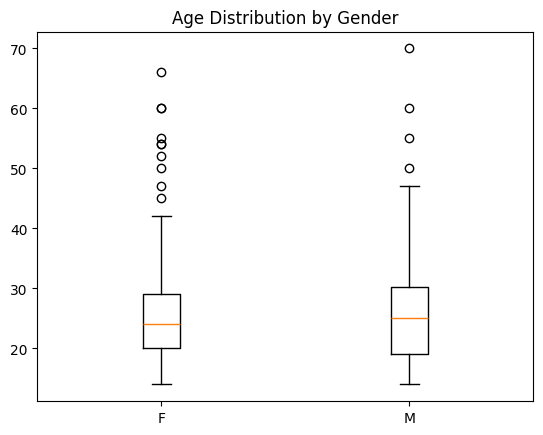

In [220]:
nonnull_gender = gender_age["Gender"].notnull().sum()
nonnull_age = gender_age["Age"].notnull().sum()
print("% of Users that declared Gender: ", nonnull_gender/len(numbers))
print("% of Users that declared Gender: ", nonnull_age/len(numbers))
female = gender_age[(gender_age["Age"].notnull()) & (gender_age["Gender"] == "F")]["Age"]
male = gender_age[(gender_age["Age"].notnull()) & (gender_age["Gender"] == "M")]["Age"]
plt.title("Age Distribution by Gender")
plt.boxplot([female,male], positions=[1,2])
plt.xticks([1,2],['F','M'])

In [221]:
gender_age.head(5)
gender_age.to_csv('gender_age.csv',index=False)

# Post Score

Ups it nominal I think

In [28]:
score_col = df['ups']

In [29]:
print(f"Length of ups: {len(score_col)}")
print(f"Mean of ups: {score_col.mean()}")
print(f"Median of ups: {score_col.median()}")
print(f"First Quantile: {score_col.quantile(0.25)}")
print(f"50th Percentile: {score_col.quantile(0.5)}")
print(f"75th Percentile: {score_col.quantile(0.75)}")
q3 = score_col.quantile(0.75)
q1 = score_col.quantile(0.25)
iqr = score_col.quantile(0.75) - score_col.quantile(0.25)
print(f"IQR: {score_col.quantile(0.75) - score_col.quantile(0.25)}")

Length of ups: 849
Mean of ups: 1261.5170789163722
Median of ups: 12.0
First Quantile: 1.0
50th Percentile: 12.0
75th Percentile: 692.0
IQR: 691.0


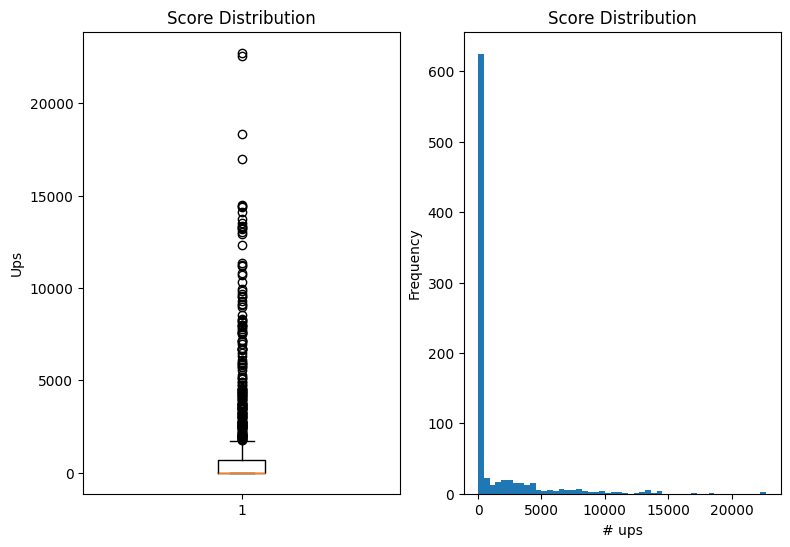

In [30]:
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.boxplot(score_col)
plt.title("Score Distribution")
plt.ylabel("Ups")

plt.subplot(1,2,2)
plt.hist(score_col, bins=50)
plt.title("Score Distribution")
plt.ylabel("Frequency")
plt.xlabel("# ups")

plt.show()
 

Length of temp data:  469


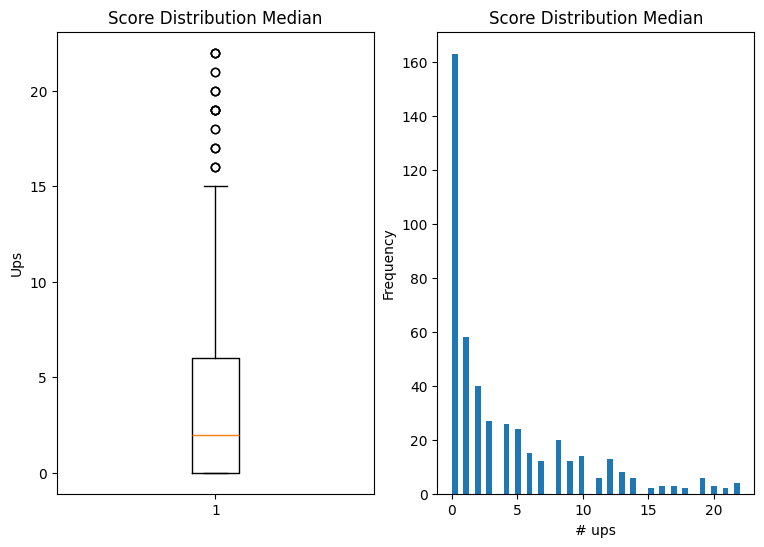

In [31]:
temp_data = score_col[score_col <= score_col.quantile(0.55) ]
print(f"Length of temp data:  {len(temp_data)}")
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.boxplot(temp_data)
plt.title("Score Distribution Median")
plt.ylabel("Ups")
# plt.ylim(0, np.percentile(score_col, 25))

plt.subplot(1,2,2)
plt.hist(temp_data, bins=50)
plt.title("Score Distribution Median")
plt.ylabel("Frequency")
plt.xlabel("# ups")
# plt.xlim(0, np.percentile(score_col, 90))

plt.show()

Length of temp data:  637


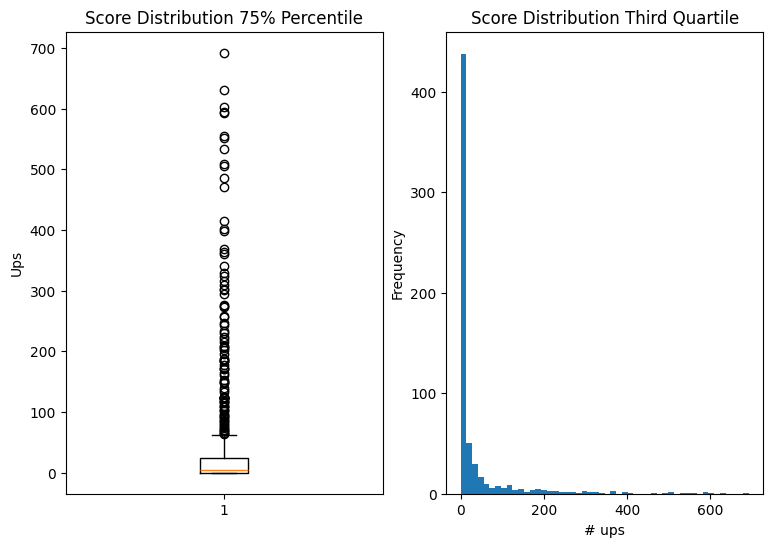

In [32]:
temp_data = score_col[score_col <= score_col.quantile(0.75) ]
print(f"Length of temp data:  {len(temp_data)}")
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.boxplot(temp_data)
plt.title("Score Distribution 75% Percentile")
plt.ylabel("Ups")
# plt.ylim(0, np.percentile(score_col, 25))

plt.subplot(1,2,2)
plt.hist(temp_data, bins=50)
plt.title("Score Distribution Third Quartile")
plt.ylabel("Frequency")
plt.xlabel("# ups")
# plt.xlim(0, np.percentile(score_col, 90))

plt.show()

In [33]:
pd.set_option('display.max_colwidth', None)
score_0 = df[df['ups'] == 0]
print(f"post source: {score_0['url'].iloc[0]}")
print()

print(f"post-content: {score_0['text_content'].iloc[0]}")


post source: https://www.reddit.com/r/AmItheAsshole/comments/1h2cd6o/aita_for_making_my_uncle_walk_away_from_dinner/

post-content: b' i used chat gpt btw since i suck at storytelling but this is true.. I (F17) wasn\xe2\x80\x99t originally invited to dinner, but my cousin thought our uncle (M40+) was visiting our house. It turned out they were going to my cousin\xe2\x80\x99s house for dinner, so I decided to tag along. From the moment we arrived, my uncle and others kept commenting on my table manners, like saying I should eat with my mouth closed. When they didn\xe2\x80\x99t like the food at the restaurant, I asked if I could finish what they didn\xe2\x80\x99t want, and they made a comment like, \xe2\x80\x9cBeggars can\xe2\x80\x99t be choosers.\xe2\x80\x9d They\xe2\x80\x99ve always picked on me during family gatherings\xe2\x80\x94making jokes about my behavior, telling me I should \xe2\x80\x9cact like a proper girl,\xe2\x80\x9d and even cutting me off when I sing karaoke. At dinner, m

In [34]:
pd.reset_option('display.max_colwidth')

# Comment Tables

In [35]:
comments_tables_df = []
 
for table in tables[1:]:
    temp = pd.read_sql_query(f"SELECT * FROM {table[0]}", connection)
    if 'Judgement_Bot_AITA' in temp["author"]:
        temp = temp.drop(temp.index[temp["author"]=='Judgement_Bot_AITA'], axis=0)
    if 'AutoModerator' in temp["author"]:
        temp = temp.drop(temp.index[temp["author"]=='AutoModerator'], axis=0)
    comments_tables_df.append(temp)

In [36]:
comments_tables_df[5]

,post_id,comment_id,content,ups,author
0,t3_1h2bxzj,t1_lzi59bj,b' Welcome to r/AmITheAsshole. Please view our...,1,Judgement_Bot_AITA
1,t3_1h2bxzj,t1_lzi68xi,"b' Sorry, but you are one of three roommates. ...",1,Waste_Worker6122
2,t3_1h2bxzj,t1_lzi6k0p,"b' YTA. They\'re roommates, they have a right ...",1,growsonwalls
3,t3_1h2bxzj,t1_lzi5ps9,b' INFO: Why 8PM? That sounds extremely early ...,1,Equivalent-Car-997
4,t3_1h2bxzj,t1_lzi7kow,"b"" YTA for making boundaries on an apt you sha...",1,Aggressive_Cattle320
5,t3_1h2bxzj,t1_lzi6bfz,"b"" 8 pm is insane. Assuming any of them work a...",1,DaveyDumplings
6,t3_1h2bxzj,t1_lzi9fp7,"b"" YTA 8 pm, are you serious? I had a later ti...",1,smoke4141
7,t3_1h2bxzj,t1_lzi4m3b,b' AUTOMOD Thanks for posting! This comment is...,1,AutoModerator
8,t3_1h2bxzj,t1_lzi9pt7,"b' YTA, 8 is ridiculous, you\xe2\x80\x99re not...",1,SnooRadishes8848
9,t3_1h2bxzj,t1_lziamcl,b' Agreements among roommates are generally ne...,1,stannenb


# Train Word2Vec + More Processing

In [ ]:
# For padding
sequence_length = 22
# Embedding dimensions. # Dimensions for each word vector
dims = 70

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

We will separate the posts sentences.

In [ ]:
def custom_standardization_tf(input_data):
    #Should I remove stop words? 
    input_data = tf.strings.regex_replace(input_data, r'[?():,\'".]', '')
    input_data = tf.strings.lower(input_data)
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,'[%s]' % re.escape(string.punctuation), '')

In [ ]:
print(f"There are {len(tokenized_sentences)} tokenized sentences")
batch_size = 5
# batch size must be a multiple of # sentences

In [ ]:
vocab_size = len(set(all_word_tokens))

In [ ]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization_tf,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
vectorize_layer.adapt(all_texts)

In [ ]:
tensor = tf.convert_to_tensor(all_texts, dtype=tf.string)
dataset = tf.data.Dataset.from_tensor_slices(tensor)
vectorize_layer.adapt(dataset)
inverse_vocab = vectorize_layer.get_vocabulary()
AUTOTUNE = tf.data.AUTOTUNE
text_vector_ds = dataset.prefetch(AUTOTUNE).map(vectorize_layer)
sequences = list(text_vector_ds.as_numpy_iterator())

In [ ]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    
  targets, contexts, labels = [], [], []

  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  for sequence in tqdm.tqdm(sequences):

    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,seed=42)

    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=42,
          name="negative_sampling")

      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=4,
    num_ns=4,
    vocab_size=vocab_size,
    seed=42)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

In [ ]:
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [ ]:
word2vec = Word2Vec(vocab_size, dims)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()
out_v = io.open(f'vectors_{dims}dim.tsv', 'w', encoding='utf-8')
out_m = io.open(f'metadata_{dims}dim.tsv', 'w', encoding='utf-8')
word_to_index = {}
for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    word_to_index[word] = index
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [21]:
words = []
with open('metadata_70dim.tsv', 'r', encoding='utf-8') as f_m:
    for line in f_m:
        word = line.strip()
        words.append(word)

# Read vectors
vectors = []
with open('vectors_70dim.tsv', 'r', encoding='utf-8') as f_v:
    for line in f_v:
        # Split line by tab and convert each element to float
        vec = [float(x) for x in line.strip().split('\t')]
        #print(vec)
        vectors.append(vec)

word_to_index = {}
for word,v in zip(words,vectors):
     word_to_index[word] = v
  

# Convert Sentences to Groups of Vectors

In [26]:
df['url'].iloc[0]

'https://www.reddit.com/r/AmItheAsshole/comments/1h2ck8c/aita_for_offering_to_buy_my_aunt_a_birthday_gift/'

In [27]:
def remove_stopwords(sen):
    sen_ = " ".join([i for i in sen.split() if i not in stop_words])
    return sen_

In [28]:
posts_texts=df["text_content"]

In [29]:
posts_texts[0]

b' Hello Reddit! Ok so a few days ago my aunt asked the family group chat if one of us could buy her a cheap computer for her birthday. I told her I would. My mom messaged me separately saying that I couldn\xe2\x80\x99t buy it, that my aunt could pay for it herself and that if I had money to buy a computer, I had money to buy myself new tires. Backstory, my birthday was a few weeks ago and I asked my dad to pay for my tires. Now, I didn\xe2\x80\x99t ask out of necessity, as I can buy my own tires, but he didn\xe2\x80\x99t know what else to get me, so I just suggested that. Back to my mom, I told her that she wasn\xe2\x80\x99t the one paying for the tires, so I didn\xe2\x80\x99t understand why she cared. She said she would tell my dad, basically saying that she would make it so he wouldn\xe2\x80\x99t pay for them. Am I crazy or is that petty and manipulative? My sister is kinda on my mom\xe2\x80\x99s side and said that she understands why she\xe2\x80\x99s upset but I\xe2\x80\x99m confus

In [37]:
# posts_texts = list of strings each containing a post content
posts_list = []
# for i, post_text in enumerate(posts_texts):
for i, post_text in enumerate(posts_texts):
    single_post = []
    post_text = post_text.decode('utf-8')
    post_text = re.split('[!?.]', post_text)
    
    #print("post_text: ", post_text)
    for sentence in post_text:  
        sentence = re.sub(r'[!?():;,\'"”._’`]', '', sentence)
        sentence = sentence.strip()
        sentence = re.sub(r'\d+','',sentence)    
        sentence = remove_stopwords(sentence)
        sentence = sentence.lower()
        
    
        sentence = contractions.fix(sentence)
        #print("after: ", sentence)
    
    
    #sentence = sentence.lower()   
        if sentence and sentence != ' ':
            single_post.append(sentence)
    posts_list.append(single_post)

In [38]:
dims=70

In [39]:
from sklearn.cluster import KMeans
from nltk import pos_tag

In [40]:
n_sentences = 12

In [ ]:
word_embeddings = {}
vectorized_sentence = []
# this is supposed to be applied to all words in vocab
for word in all_word_tokens:
    try:
        vector=np.array(word_to_index[word])
        word_embeddings[word] = np.array(word_to_index[word])
        vectorized_sentence.append(vector)
    except KeyError:
        continue


In [48]:
def pos_tag_only_nouns(single_post):
    new = []
    
    for s in single_post: 
        tokenized_sentences_ = remove_stopwords(s)
        tokenized_sentences_ = [w.strip() for w in tokenized_sentences_.split()]
        tokenized_sentences_ = pos_tag(tokenized_sentences_)
        
        for word,tag in tokenized_sentences_:      
            if tag == 'NN':
                new.append(word)
 
    return list(set(new))

In [ ]:
d = np.array(word_embeddings.get('reddit'.lower(), np.zeros((dims,)))) #+ word_embeddings.get('Hello'.lower(), np.zeros((dims,)))
d.shape
d

In [50]:
def make_list_sentence_vectors(single_post, dims,word_embeddings):
    
    sentence_vectors = []
    for s in single_post:

        if len(s) != 0:
            v = sum([np.array(word_embeddings.get(w.lower(), np.zeros((dims,)))) for w in s.split()])/ len(s.split()) +0.01
            
        else:
            v = np.zeros(dims)
            
        sentence_vectors.append(np.array(v))
    return sentence_vectors

In [ ]:
sentence_vectors = make_list_sentence_vectors(single_post=posts_list[0], dims=dims,word_embeddings=word_embeddings)

In [51]:
def make_sim_matrix_0s(n_rows_cols):
    sim_mat = np.zeros([n_rows_cols, n_rows_cols])
    return sim_mat

# Attempt clustering word

In [53]:
def make_word_tokens(clean_sentences_single_post):

    word_tokens = list(set(w for s in clean_sentences_single_post for w in s.split()))
    return word_tokens

In [ ]:
word_tokens = make_word_tokens(clean_sentences_nouns)

In [54]:
def get_word_embeddings_from_tokens(word_tokens, dims):
    for i,w in enumerate(word_tokens):
        T_weights_words = word_embeddings.get(w, np.zeros((dims,)))
        T_weights_words = T_weights_words.reshape(-1)
        weights_df.iloc[i] = T_weights_words
    return weights_df

In [ ]:
vector_shape = (dims,)

In [56]:
def make_cosine_similarity_adjancy_matrix(**kwargs):
    try:
        if 'single_vector_list' in kwargs:
            vector_list_1 = kwargs['single_vector_list']
            vector_list_2 = kwargs['single_vector_list']
        else:
            vector_list_1 = kwargs['vector_list_1']
            vector_list_2 = kwargs['vector_list_2']
    except KeyError:
        print(f"kwargs given: {kwargs.items()}, when allowed are :")
        print("- single_vector_list")
        print("- vector_list_1")
        print("- vector_list_2")
    n_rows = len(vector_list_1)
    n_cols = len(vector_list_2)
    
    if n_rows != n_cols:
        if n_rows < n_cols:
            vector_shape = vector_list_2[0].shape
            vector_zeros = [np.zeros(vector_shape) for _ in range(n_cols-n_rows )]
            vector_list_1 = vector_list_1 + vector_zeros 
            n_rows = len(vector_list_1)
        elif n_rows > n_cols:
            vector_shape = vector_list_1[0].shape
            vector_zeros = [np.zeros(word_vector_shape) for _ in range(n_rows - n_cols )]
            vector_list_2 = vector_list_2 + vector_zeros 
            n_cols = len(vector_list_2)
    else:
        vector_shape = vector_list_1[0].shape
  
    sim_mat = make_sim_matrix_0s(n_rows)
    for i in range(n_rows):
        for j in range(n_cols):
            if i != j:
                sim_mat[i][j] = cosine_similarity(vector_list_1[i].reshape(1,dims), vector_list_2[j].reshape(1,dims))[0,0]
    return sim_mat

In [ ]:
n_sentences = len(sentence_vectors)
sim_mat = make_cosine_similarity_adjancy_matrix(single_vector_list =sentence_vectors)

In [ ]:
print("N_setnences: ",len(sentence_vectors))
print("Vector word length: ",len(sentence_vectors[1]))

In [ ]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(clean_tokenized_sentences)), reverse=True)

In [57]:
def word_vectors(word_tokens,dims):
  
    print("length of clean_words_unique: ",len(word_tokens))
    word_vectors= []
    for w in word_tokens:
                
        v = word_embeddings.get(w, np.zeros((dims,)))
        word_vectors.append(v)
      
     
    return word_vectors

In [59]:
def apply_pageRank(sim_matrix, list_items_compared_sim_matrix):
    # returns top ranked things
    nx_graph = nx.from_numpy_array(sim_matrix)
    #print(nx_graph)
    #pos = nx.spring_layout(nx_graph)
    #nx.draw_networkx_nodes(nx_graph, pos, node_size=500)
    #nx.draw_networkx_edges(nx_graph, pos, edgelist= nx_graph.edges(), width=2)
    #nx.draw_networkx_labels(nx_graph, pos)
    #scores = nx.pagerank(nx_graph, max_iter=100,tol=1.0e-3)
    pagerank = PageRank()
    scores = pagerank.fit_predict(sim_matrix)
    #scores = nx.pagerank_scipy(nx_graph)
    ranked_ = sorted(((scores[i],s) for i,s in enumerate(list_items_compared_sim_matrix)), reverse=True)
    return ranked_

In [60]:
df_keywords = pd.DataFrame(
    [['' for _ in range(7)] for _ in range(849)],
    #np.empty((849, 7)),   
    columns=["keyword_1", "keyword_2", "keyword_3", "keyword_4", "keyword_5", "keyword_6", "keyword_7"]
)
df_keywords_scores = pd.DataFrame(
    np.zeros((849, 7)),   
    columns=["keyword_1", "keyword_2", "keyword_3", "keyword_4", "keyword_5", "keyword_6", "keyword_7"]
)

# ANALYSIS

In [63]:
def extract_top_sentences_words(posts_list, dims, word_embeddings):
    list_posts_top_ranked_s = []
    list_posts_top_ranked_w = []
    sum_of_scores =[]
    
    for i,post in enumerate(posts_list):
        n_sentences = len(post)
        sentence_vectors = make_list_sentence_vectors(single_post=post, dims=dims,word_embeddings=word_embeddings)
        # make sim matrix
        sim_matrix_s = make_cosine_similarity_adjancy_matrix(single_vector_list=sentence_vectors)
        # getting only nouns 
        only_nouns_sentences = pos_tag_only_nouns(single_post=post)
        # getting word tokens for words indiidually and placing them in list
        word_tokens = only_nouns_sentences
        word_vectors_ = word_vectors(word_tokens, dims)
        sentence_vectors = make_list_sentence_vectors(single_post=post, dims=dims,word_embeddings=word_embeddings)
        sim_matrix_w = make_cosine_similarity_adjancy_matrix(vector_list_1=word_vectors_, vector_list_2=word_vectors_)
        
        ranked_words = apply_pageRank(sim_matrix_w, word_tokens)

        page_rank_scores, page_rank_label = zip(*ranked_words)
        sum_ = sum(page_rank_scores)
 
        list_posts_top_ranked_w.append(ranked_words)
        try:
            current_sum = 0
            df_keywords.at[i,"keyword_1"] = str(ranked_words[0][1])  
            df_keywords_scores.at[i,"keyword_1"] = (ranked_words[0][0])
            current_sum += ranked_words[0][0]
            
            df_keywords.at[i,"keyword_2"] = str(ranked_words[1][1])
            df_keywords_scores.at[i,"keyword_2"] = (ranked_words[1][0])
            current_sum +=ranked_words[1][0]
            
            df_keywords.at[i, "keyword_3"] = str(ranked_words[2][1])
            df_keywords_scores.at[i, "keyword_3"] = (ranked_words[2][0])
            current_sum +=ranked_words[2][0]
            
            df_keywords.at[i, "keyword_4"] = str(ranked_words[3][1])
            df_keywords_scores.at[i, "keyword_4"] = ranked_words[3][0]
            current_sum +=ranked_words[3][0]
            
            df_keywords.at[i, "keyword_5"] = str(ranked_words[4][1])
            df_keywords_scores.at[i, "keyword_5"] = (ranked_words[4][0])
            current_sum +=ranked_words[4][0]
            
            df_keywords.at[i, "keyword_6"] = str(ranked_words[5][1])
            df_keywords_scores.at[i, "keyword_6"] = (ranked_words[5][0])
            current_sum +=ranked_words[5][0]
            
            df_keywords.at[i, "keyword_7"] = str(ranked_words[6][1])
            df_keywords_scores.at[i, "keyword_7"] = (ranked_words[6][0])
            current_sum +=ranked_words[6][0]
        except IndexError:
            sum_of_scores.append(current_sum)
            
            continue
        sum_of_scores.append(current_sum)
     
    return list_posts_top_ranked_s, list_posts_top_ranked_w, word_tokens,sum_of_scores

In [ ]:
list_posts_top_ranked_s, list_posts_top_ranked_w, word_tokens,sum_of_scores = extract_top_sentences_words(posts_list, dims, word_embeddings)

829


Text(0, 0.5, 'Proportion')

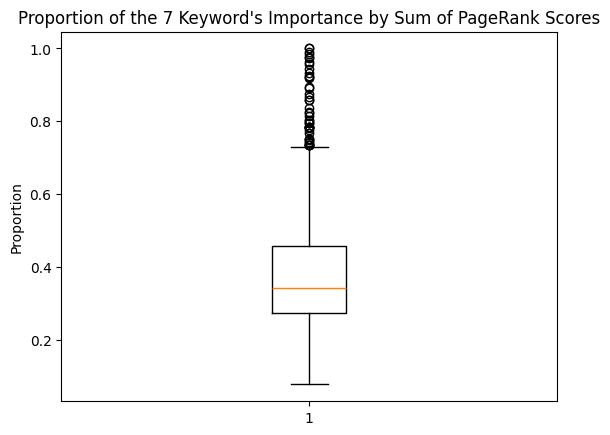

In [66]:
# get % of score
pct_list = []
for i in df_keywords_scores.index:
    pct =sum_of_scores[i]
    if pct >=1.01:
        continue
    pct_list.append(pct)
print(len(pct_list))
plt.boxplot(pct_list) 
plt.title("Proportion of the 7 Keyword's Importance by Sum of PageRank Scores")
plt.ylabel("Proportion")

In [67]:
columns = df_keywords.columns
df_keywords["mean"]=[0]* 849
means = []

all_ = []
for i in range(105):
    values = [word_embeddings.get(keyword, np.zeros((dims,))) for keyword in df_keywords.iloc[i,:7].values]
    all_.append(values)


In [68]:
len(np.unique(all_word_tokens))
all_word_tokens[0]

'hello'

In [69]:
 
def find_closest_word(vector):
    max_similarity = -1
    closest_word = None
    
    for word in all_word_tokens:
        w =word_embeddings.get(word, np.zeros((dims,)))
        if sum(w) !=0:
            similarity = np.dot(w, vector) / (np.linalg.norm(w) * np.linalg.norm(vector))
            if similarity > max_similarity:
                max_similarity = similarity
                closest_word = word
    return closest_word

In [71]:
keywords = list(df_keywords["keyword_1"].unique())

In [72]:
print(len(keywords))

414


(105, 490)


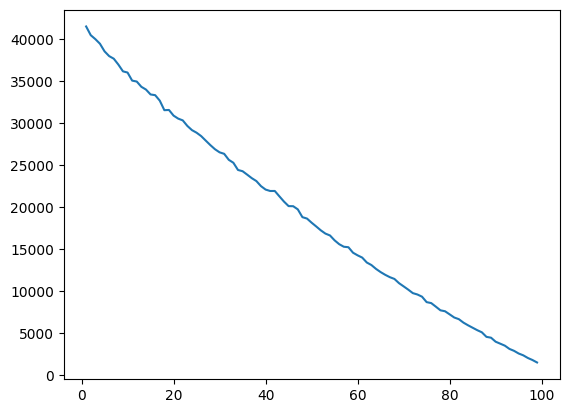

In [73]:
l = []
sse = []
all_ = np.array(all_)
all_ = all_.reshape((-1,490))
print(all_.shape)
for i in range(1,100):
    kmeans_topics = KMeans(n_clusters=i)
    kmeans_topics.fit(all_)
    sse.append(kmeans_topics.inertia_)
plt.plot(range(1,100), sse)

In [ ]:
kmeans_topics = KMeans(n_clusters=20)
kmeans_topics.fit(all_)
labels = kmeans_topics.labels_
keywords_labels = {}
for i,l in enumerate(labels):
    if l in keywords_labels:
        keywords_labels[l].append(i)
    else:
        keywords_labels[l] =[i] 

In [ ]:
keywords

Len:  16
Len:  16
Len:  16
Len:  16
Len:  16
Len:  16
Len:  16


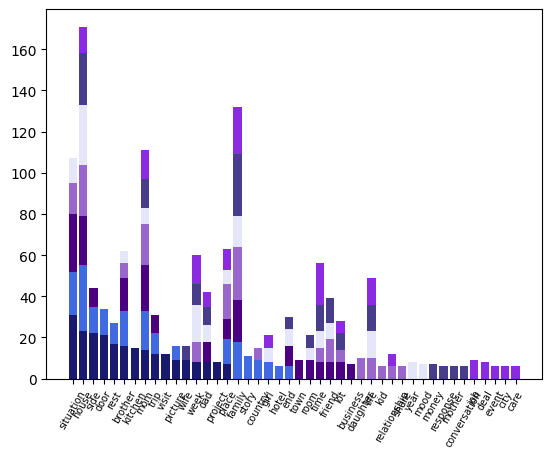

In [79]:
value_counts_keywords = {}
 
keywords_counts = []
cum_heights = {}
colors = ['#191970', '#4169E1', '#4B0082', '#9966CC', '#E6E6FA', '#483D8B', '#8A2BE2']

for i in range(7):
    keywords=df_keywords.iloc[:,i].value_counts()
    key_keyindices=[(count,word) for count, word in zip(keywords, keywords.index) if count >= keywords.quantile(0.95)]
    
    if len(key_keyindices) >15:
        key_keyindices =key_keyindices[:16]
 
    for c,w in key_keyindices:
        if w not in cum_heights:
            cum_heights[w] = 0
    
        plt.bar(w,c,bottom=cum_heights[w], color=colors[i])     
        cum_heights[w] +=c
 
        
    plt.xticks(rotation=60,fontsize=7)
    
    #plt.legend()
plt.title("") 
plt.show() 

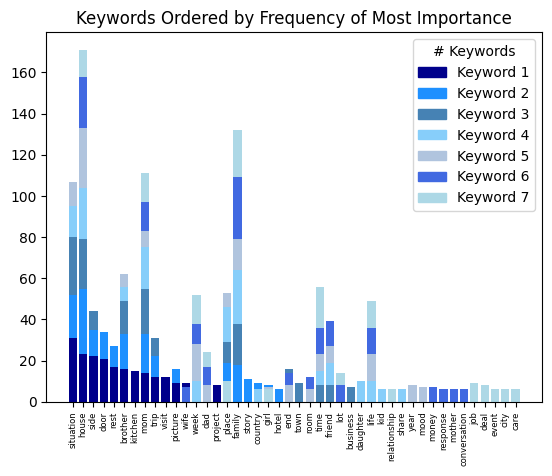

In [162]:
value_counts_keywords = {}
import matplotlib.patches as mpatches
keywords_counts = []
cum_heights = {}
colors = ['#00008B', '#1E90FF', '#4682B4', '#87CEFA', '#B0C4DE', '#4169E1', '#ADD8E6']

for i in range(7):
    keywords=df_keywords.iloc[:,i].value_counts()
    key_keyindices=[(count,word) for count, word in zip(keywords, keywords.index) if count >= keywords.quantile(0.95)]
    
    if len(key_keyindices) >15:
        key_keyindices =key_keyindices[:16]
        
    for c,w in key_keyindices:
        if w not in cum_heights:
            cum_heights[w] = [0]*7
    
        plt.bar(w,c,bottom=cum_heights[w][i], color=colors[i])
        cum_heights[w][i] += c
        if i < 6:
            cum_heights[w][i+1] = (cum_heights[w][i])
       
            
 
        
    plt.xticks(rotation=90,fontsize=6)
    
    #plt.legend()
 
handle1 = mpatches.Patch(color='#00008B', label='Keyword 1')
handle2 = mpatches.Patch(color='#1E90FF', label='Keyword 2')
handle3 = mpatches.Patch(color='#4682B4', label='Keyword 3')
handle4 = mpatches.Patch(color='#87CEFA', label='Keyword 4')
handle5 = mpatches.Patch(color='#B0C4DE', label='Keyword 5')
handle6 = mpatches.Patch(color='#4169E1', label='Keyword 6')
handle7 = mpatches.Patch(color='#ADD8E6', label='Keyword 7')
handles  = [handle1,handle2 ,handle3,handle4,handle5,handle6,handle7]
plt.legend(handles=handles, title='# Keywords')
plt.title('Keywords Ordered by Frequency of Most Importance')
plt.show() 

In [ ]:
cum_heightsc = cum_heights.copy()

In [81]:
def get_total_counts(word, df_):
    val = 0
    for i in range(df.shape[1]):
        val += get_col_count(i,word,df_)
    return val ,word

def get_col_count(col,word,df_):
    d = df.iloc[:, col].value_counts()
    return d.get(word,0)

In [ ]:
sum_key = [get_total_counts(word, df_keywords) for word, lst in cum_heightsc.items()]
sum_key = (sorted(sum_key))

In [ ]:
np.unique(labels, return_counts=True)

# TSNE

In [88]:
glove_path ='glove.6B.100d.txt'

In [89]:
embeddings_dict = {}

vectors =[]
with open(f'{glove_path}', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

    

In [90]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

In [91]:
def find_distance_embedding(embedding_1, embedding_2):
    return spatial.distance.euclidean(embedding_1, embedding_2)

In [94]:
keysw = df_keywords.iloc[0].tolist()
matrix_distances = np.zeros((7,7)) 
for i in range(7):
    for j in range(7):
        dis = find_distance_embedding( embeddings_dict[keysw[i]], embeddings_dict[keysw[j]])
        matrix_distances[i][j] = dis

In [96]:
uniques = []
for column in df_keywords.columns:
    uniques.extend(df_keywords[column].unique())
   

In [97]:
vectors = np.array([embeddings_dict.get(word,np.zeros(100,)) for word in uniques])

In [98]:
uniques_cleaned = []
for w in uniques:
    e = embeddings_dict.get(w,None)
    if e is not None:
        uniques_cleaned.append(w)

In [100]:
tsne = TSNE(n_components=2, random_state=0)

In [101]:
Y = tsne.fit_transform(vectors[:])

Text(0.5, 0, ' 2nd Component')

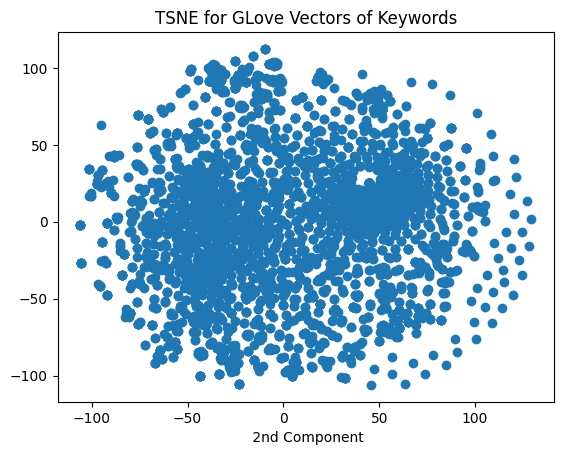

In [247]:
plt.scatter(Y[:,0],Y[:,1])

plt.title("TSNE for GLove Vectors of Keywords")
plt.xlabel("1st Component")
plt.xlabel(" 2nd Component")

In [272]:
hdb = HDBSCAN(min_cluster_size=5)
hdb.fit(vectors)
labels = hdb.labels_

In [271]:
len_unique = len(set(labels))
print(f"# labels: {len_unique}, # unique keywords: {len(labels)}")
labels_unique = list(set(int(label) for label in labels))

# labels: 204, # unique keywords: 3188


In [159]:
ci_low, ci_high = smp.proportion_confint(64, 100, alpha=0.05, method='normal')
ci_low, ci_high

(0.5459217287420775, 0.7340782712579226)

In [ ]:
plt.scatter(Y[:,0],Y[:,1])
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points", fontsize=0)
    plt.title("TSNE for GLove Vectors of Keywords")
    plt.xlabel("1st Component")
    plt.xlabel(" 2nd Component")

In [274]:
labels_hdbscan = {}
for l, w in zip(labels, uniques_cleaned):
    if l not in labels_hdbscan:
        labels_hdbscan[l]=[w]
    else:
        labels_hdbscan[l].append(w)
    

In [320]:
agglomerative_avg = AgglomerativeClustering(distance_threshold=0,n_clusters=None,linkage='average').fit(vectors)
agglomerative_com = AgglomerativeClustering(distance_threshold=0,n_clusters=None,linkage='complete').fit(vectors)

In [299]:
labels = agglomerative_avg.labels_

In [303]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    #den_dic = dendrogram(linkage_matrix, **kwargs)
    #return den_dic

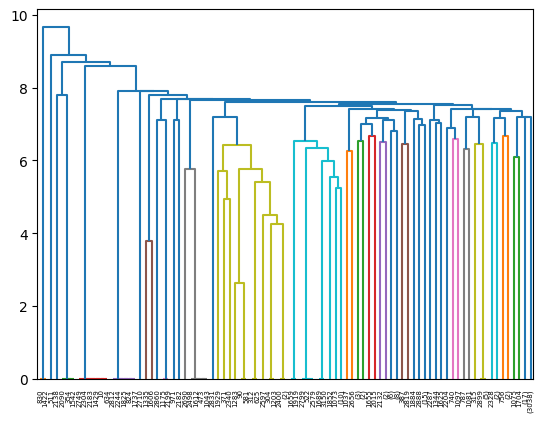

In [321]:
plot_dendrogram(agglomerative_avg, truncate_mode='level', p=17)

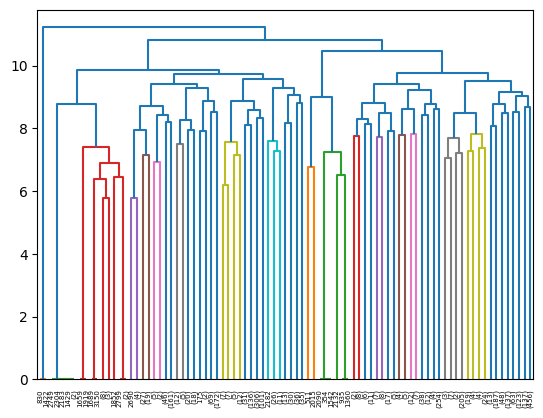

In [325]:
plot_dendrogram(agglomerative_com, truncate_mode='level', p=7)

In [338]:
agglomerative_com = AgglomerativeClustering(n_clusters=10,linkage='complete').fit(vectors)
labels = agglomerative_com.labels_

In [334]:
labels_unique = list(set(int(label) for label in labels))

In [332]:
def make_dictionary_(labels, uniques_cleaned=uniques_cleaned):
    labels_agglo_ward = {}
    for l, w in zip(labels, uniques_cleaned):
        if l not in labels_agglo_ward:
            labels_agglo_ward[l]=[w]
        else:
            labels_agglo_ward[l].append(w)
    return labels_agglo_ward

In [103]:
df_keywords.drop(["mean"], axis=1,inplace=True)

In [104]:
df_embeddings_dic = {}
df_embeddings = pd.DataFrame(columns=df_keywords.columns)
for col in df_keywords.columns:
    df_embeddings[col] = df_keywords[col].apply(lambda x: embeddings_dict.get(x,(100,)) )
 

In [ ]:
rows =[]
row = []
 
for i in df_keywords.index: #for row
    row= []
    for col in df_keywords.columns: # for col
        array = df_embeddings.at[i,col]
        row.extend(array)
    rows.append(row)
        
flattened_embeddings = pd.DataFrame(rows)       
flattened_embeddings = flattened_embeddings.fillna(0)       

In [423]:
hdb = HDBSCAN(min_cluster_size=7, metric = 'l1')
hdb.fit(flattened_embeddings)
labels = hdb.labels_

In [422]:
agglomerative_avg = AgglomerativeClustering(n_clusters=17,linkage='average').fit(flattened_embeddings)# ,
print("Average: ", len(set(agglomerative_avg.labels_)))
labels = agglomerative_avg.labels_
agglomerative_com = AgglomerativeClustering(n_clusters=35,linkage='ward').fit(flattened_embeddings)
print("ward: ", len(set(agglomerative_com.labels_)))
labels = agglomerative_com.labels_

Average:  17
ward:  35


In [ ]:
# check against instance by instnance to see how well classifies
for i, l in zip(df_keywords.index,labels):
    if l == np.int64(16):
        print(df_keywords.iloc[i])

In [419]:
dbscan = DBSCAN(eps=7.5, min_samples=4).fit(flattened_embeddings)
dbscan_labels = dbscan.labels_

Counter({np.int64(-1): 849})

In [ ]:
x= df_embeddings.head(10)
vectors = []
for i in x.index:
    mean = df_embeddings.iloc[i].sum() / df_embeddings.shape[1]
    vectors.append(df_embeddings.iloc[i])
    y = find_closest_embeddings(mean)
    y= y[:10]
 

In [111]:
def find_closest_embeddings_(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

# Extracting Topics

In [166]:
topics = ["family", "parents", "kids", "children", "money",
          "relationship", "boyfriend","girlfriend","ethic", "workplace","wedding", "pets", "norms", "etiquette",
          "neighbor","married","friendship", "friend","animal","pet","animals","health","friends","husband", "wife","fiance",
         "coworker","roommate","boundaries","rules", "stranger","disrespectful", "trust", "respect", "privacy", "responsability"
         , "priorities", "chores","grandparents","grandpa","grandma", "aunt","uncle","sister","brother","daughter","son","father","son","mother","presure","fiance"] #,"dad","mom" alcohol

In [167]:
topic_vectors = [embeddings_dict[word] for word in topics]

In [168]:
selected_keyword = pd.DataFrame(
    np.zeros((849, 2)),   
    columns=["score", "keyword"])
 
selected_keyword["keyword"] = selected_keyword["keyword"].astype(str) 

for i in df_keywords.index: # rows
 
    vectors_i = df_embeddings.iloc[i] 
    group = []
    weights = list(df_keywords_scores.iloc[i])
    weights = [round((weight/sum(weights))+1, 3) for weight in weights]

    for i_c, v in enumerate(vectors_i): # cols
        min_dis = 10
        min_dis_w = ''
        tupples_dis_words = []
        temp = {}
        for t, t_w in zip(topic_vectors, topics):
            dis = find_distance_embedding(t,v)            
            tupple_dis_w = (float(dis),t_w)
            tupples_dis_words.append(tupple_dis_w)
            
        tupples_dis_words = sorted(tupples_dis_words)
        group.append(tupples_dis_words[0])     

    i_, w_ = zip(*group)
    i_ = np.array(i_)
    i_ = i_.reshape(-1,1)
    i_ = scaler.fit_transform(i_)
    i_ = [1 - int_i_ for int_i_ in i_]
    group = list(zip(i_,w_))
    group_weighted = [((score_i * weight), word_i)  for weight,(score_i, word_i) in zip(weights,group)]
    group_weighted = sorted(group_weighted, reverse=True)
 
    score = group_weighted[0][0]
    score =score[0]
    selected_keyword.at[i,"score"]=  score
    selected_keyword.at[i,"keyword"]= str(group_weighted[0][1])
 

In [153]:
def normalize(val, lst):
    return ( val - max(lst) ) / (max(lst) - min(lst))

In [207]:
pd_to_excel = pd.DataFrame(selected_keyword)
pd_to_excel["text"] = posts_list

In [208]:
pd_to_excel.to_csv('keyword_post.csv', index=False)

In [209]:
value_counts = pd_to_excel["keyword"].value_counts()

In [210]:
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['keyword', 'count']
value_counts_df = value_counts_df.set_index('keyword')  

In [211]:
sum(pd_to_excel["keyword"].value_counts())

849

In [213]:
correct_df = 
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['keyword', 'count']
value_counts_df = value_counts_df.set_index('keyword')   

 
family_count = value_counts_df.loc[["family", "brother", "mother", "kids", "daughter", 
                                    "aunt", "father", "uncle", "son", "children", 
                                    "grandma", "parents","sister"], "count"].sum()

friends_count = value_counts_df.loc[["friends", "friend", "friendship"], "count"].sum()

relationship_count = value_counts_df.loc[["relationship", "wedding", "wife", "husband","fiance","boyfriend","girlfriend"], "count"].sum()

work_count = value_counts_df.loc[["coworker", "workplace"], "count"].sum()

stranger_count = value_counts_df.loc["stranger", "count"]

money_count = value_counts_df.loc["money", "count"]

rules_count = value_counts_df.loc[["rules", "presure", "respect", "priorities", 
                                   "trust", "privacy", "boundaries", "disrespectful"], "count"].sum()

pet_count = value_counts_df.loc["pet", "count"]

health_count = value_counts_df.loc["health", "count"]

living_count = value_counts_df.loc[["roommate", "chores", "responsability", "neighbor"], "count"].sum()

print("Family Count:", family_count)
print("Friends Count:", friends_count)
print("Relationship Count:", relationship_count)
print("Work Count:", work_count)
print("Stranger Count:", stranger_count)
print("Money Count:", money_count)
print("Rules Count:", rules_count)
print("Pet Count:", pet_count)
print("Health Count:", health_count)
print("Living Count:", living_count)


Family Count: 319
Friends Count: 121
Relationship Count: 112
Work Count: 44
Stranger Count: 63
Money Count: 60
Rules Count: 88
Pet Count: 9
Health Count: 16
Living Count: 17


In [214]:
family_count + friends_count + relationship_count + work_count +stranger_count + money_count +rules_count+pet_count+health_count+living_count

849

In [203]:
names = [
    "family",     
    "friends",      
    "relationship", 
    "rules", 
              
    "stranger",    
    "money",      
    "work",
           
    "health",       
    "living",
"pet",]
heights = [family_count,friends_count, relationship_count,rules_count,stranger_count,money_count,work_count,
           health_count,health_count,pet_count,]

Text(0.5, 1.0, 'Frequency of Topic')

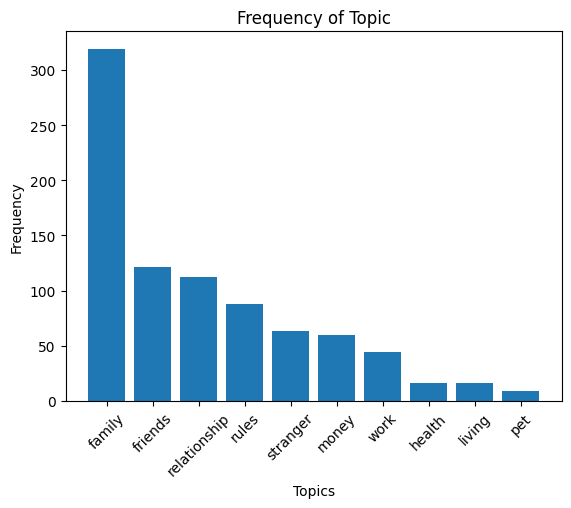

In [206]:
plt.bar(names,heights)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.xlabel("Topics")
plt.title("Frequency of Topic")